In [6]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter, defaultdict

import numpy
import pandas
from math import exp, sqrt, log

from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from keras.callbacks import EarlyStopping

from sklearn.externals import joblib

from importlib import reload
from matplotlib import pyplot as plt
from random import random, shuffle, choice, randint

from classes import Student, Question
from utils import generate_student_name, create_qs, create_students, generate_attempts, calculate_pass_probability, attempt_q

import random
import math
import scipy

from NN_utils import BigTable, WeightClip

print("started")

use_saved = True
do_train = True
do_testing = True
create_scorecards = True

base = "../../../isaac_data_files/"

from scipy.optimize import curve_fit
def gompertz(x, A,k1,k2,off):
    return A*numpy.exp(-k1*numpy.exp(-k2*(x-off)))

def inv_gompertz(y, A,k1,k2,off):
    return off + numpy.log(k1/numpy.log(A/y))/k2

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

# p = 1/(1+e(-x))
# 1+e(-x) = 1/p
# e(-x) = (1/p)-1
# x = -log((1/p)-1)

def inv_logistic(pr, b,off):
    return off-(numpy.log((1/pr) -1))/b

sigmoid = lambda z: 1/(1+(numpy.exp(-z)))
def pr(a,d): return sigmoid((a-d))
def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/comps)
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

def spread_to_pr(sp, comps=1):
    return numpy.power((1/(1+numpy.exp(-sp))), comps)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students(n_students, a0, a1, n_factors, gen_mode="truncnorm"):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.repeat(3, n_factors)
        if gen_mode=="truncnorm":
            true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#             true_comps = numpy.clip(true_comps,6,12)
        elif gen_mode=="uniform":
#             minb,maxb,mina,maxa =(1.0, 3.7812870150169404, 2.691968403956818, 12.165240419546407) # 10?

            clip0 = a0 - 3*a1
            clip1 = a0 + 3*a1
#             clip0 = mina
#             clip1 = maxa
            print("clipp",clip0,clip1)
            true_comps = numpy.random.uniform(clip0, clip1, size=n_factors)
#             true_comps = numpy.clip(true_comps,6,12)
        else:
            print("unknown distro mode")
#         print("True comps", a0,a1, true_comps)
#         true_comps = numpy.random.uniform(a0-3*a1, a0+3*a1, size=n_factors)
#         true_comps = numpy.repeat(3, n_factors)
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c + 3
    return students

def gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode="truncnorm", test_w=None):
    #approximate the min and max outputs from the gaussian
    inv_fn = spread_to_pr
    av_c = (min_active_traits + max_active_traits)/2
    p = numpy.linspace(0.001,0.999,30)
    sprd = pr_to_spread(p, av_c, as_A_and_D=False)
#     plt.scatter(sprd,p)
#     plt.show()
#     popt, pcov = curve_fit(inv_fn, p, sprd)
#     print(popt)
#     p = numpy.linspace(0.001,0.999,50)
#     d = (p, comps=av_c)
    p2 = spread_to_pr(sprd, av_c)
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    d99 = pr_to_spread(.999, av_c, as_A_and_D=False)
    d00 = pr_to_spread(.001, av_c, as_A_and_D=False)
    print("dvals", d00, d50, d99)
    print("inv_logistic curve")
    plt.scatter(sprd,p)
    plt.plot(sprd,p2)
    plt.show()
    print("tru spread d50=",d50, "(prob={})".format(spread_to_pr(d50, av_c)))
    
    minval = math.inf
    
    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
        n_comps = random_integers(min_active_traits, max_active_traits)
        print("NCOMPS", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        
        mu = a0
        sd = a1
        clip_a, clip_b = 0.0001,0.9999
#         a, b = (clip_a - mu) / sd, (clip_b - mu) / sd
#         standard_probs = scipy.stats.norm.rvs(loc=.5, scale=1/6, size=n_comps)
        if gen_mode == "u_uniform":
#             true_comps = numpy.random.uniform((mu-1)-d50, (mu+1)-d50, size=n_comps)
#             minb,maxb,mina,maxa =(1.0, 3.7812870150169404, 2.691968403956818, 12.165240419546407) # 10?
#             true_comps = numpy.random.uniform((mu-1)-d50, (mu+1)-d50, size=n_comps)
            if test_w:
                minb=-test_w/2
                maxb=test_w/2
            else:
                minb=-2
                maxb=2
            true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
#             true_comps = numpy.random.uniform(mu, sd, size=n_comps)
#             print("true q comps", true_comps)
        elif gen_mode == "c50":
            true_comps = numpy.repeat(mu-d50, n_comps)
#             true_comps = true_comps * numpy.random.normal(loc=1, scale=0.1, size=n_comps)
        elif gen_mode == "u_truncnorm":
            true_comps = numpy.random.normal(loc=mu, scale=sd, size=n_comps)
        else:
            standard_probs=[]
            if gen_mode == "truncnorm":
                standard_probs = numpy.random.normal(loc=0.5, scale=1/6, size=n_comps)
                standard_probs = numpy.clip(standard_probs,clip_a,clip_b)
            elif gen_mode == "beta22":
                standard_probs = numpy.random.beta(2,2, size=n_comps)# normal(loc=.5, scale=1/6, size=n_comps)
    #         standard_probs = truncnorm.rvs(clip_a, clip_b, loc=mu, scale=sd, size=n_comps)
            elif gen_mode == "uniform":
                standard_probs = numpy.random.uniform(clip_a, clip_b, size=n_comps)
#         standard_probs = numpy.repeat(0.5, n_comps)
            true_comps = a0 - pr_to_spread(standard_probs, comps=n_comps, as_A_and_D=False)
#             print(standard_probs,"-->",true_comps)
        
        this_min = min(true_comps)
        if this_min < minval:
            minval= this_min
        
#         plt.scatter(true_comps, standard_probs)
#         plt.show()
                
#         print("Q comps", true_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c + 3
            
        print("q minval is", minval)
        for cix,c in zip(comp_ixs,true_comps):
            if questions[qix,cix] !=0:
                questions[qix,cix] = questions[qix,cix]# - minval + 1
    return questions, minval

# minb,maxb,mina,maxa =(1.0, 11, 6, 11)
def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, s_gen="uniform", q_gen="uniform", test_w=None):
    students = gen_students(n_students, a0, a1, n_factors, gen_mode=s_gen)
    questions, offset = gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode=q_gen, test_w=test_w)

#     questions[questions>0] = questions[questions>0] - offset+1
#     students = students - offset+1
#     students = students

    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            zmask = (questions[mi] < 0.001).astype(int)
            diffs = students[vi]-questions[mi]
            prs = logistic(diffs,1,0)
            prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
#             print(vi,mi, numpy.prod(prs))
    return obs, probs, students, questions

        

dvals -4.59511985013 0.53204746933 7.31238665998
inv_logistic curve


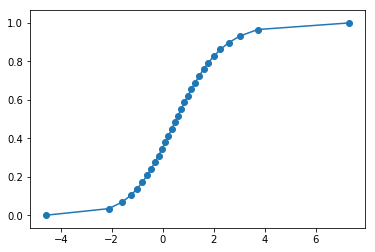

tru spread d50= 0.53204746933 (prob=0.5)
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 1
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 1
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.29687463988
NCOMPS 2
q minval is -1.32707016826
NCOMPS 1
q minval is -1.32707016826
NCOMPS 2
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 2
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 2
q minval is -1.52864907462
NCOMPS 2
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 1
q minval is -1.52864907462
NCOMPS 2
q minval is -1.52864907462
NCOMPS 2
q minval is -1

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead


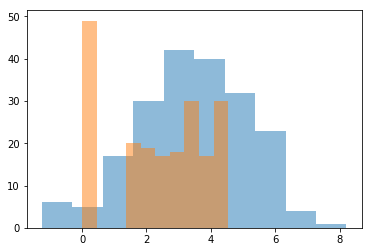

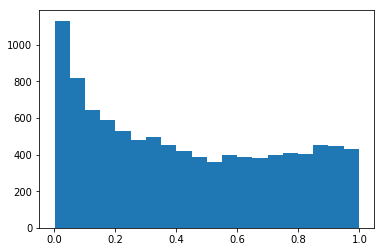

(100, 100)
100 100
10000 4298.0
0.4298
[ 0.02842567  0.03239326  0.03879349 ...,  0.03513735  0.04710692
  0.04639608]
--- -
[ 0.97906792  0.9705885   0.95981381  0.96501116  0.98073662  0.95246398
  0.95026939  0.96144433  0.96655818  0.97161339  0.97105284  0.9538326
  0.9680323   0.95278772  0.98605575  0.97204684  0.95789315  0.9816294
  0.98627935  0.96009648  0.96322078  0.9574629   0.96078497  0.97709114
  0.9699131   0.98545204  0.95963459  0.95638804  0.96101504  0.96500605
  0.98396671  0.98061944  0.97240249  0.98909749  0.99327169  0.99639443
  0.99202055  0.98529985  0.9766239   0.96474207  0.99459957  0.97791767
  0.98443167  0.95064908  0.97347022  0.99845281  0.99685878  0.97886985
  0.9681805   0.98164977  0.98997483  0.96971223  0.97491418  0.9789495
  0.97554476  0.97501543  0.96860142  0.99152757  0.97555967  0.98266933
  0.99520631  0.97372745  0.98323215  0.97222102  0.95157895  0.99795352
  0.98247448  0.97946541  0.96647296  0.97741053  0.98743691  0.98330046
  

In [9]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
# n_factors, a0, a1, min_active, max_active = (1, 0, 0.33, 1, 1)
# n_students = 100
# n_questions = 25

n_factors, min_active, max_active = (2, 1, 2)
n_students, n_questions, a0, a1, offset, test_w = (100, 100, 0.4823576844849777, 1.6871220640260116, 0.53204746933021974, 3.1292884180111837)

# n_factors, min_active, max_active = (1, 1, 1)
# # n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 1.418229380809847, 1.0692556793317223, 1.3473773483293849, 1.6818148263362849)
# #bimodal
# # n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 1.7370052886179934, 1.200184825188867, 1.3473773483293849, 2.474132956688926)
# n_students, n_questions, a0, a1, offset, test_w =(100, 100, 0, 1.2455595712463379, 0.185, 1.6418978406981621)

# n_factors, min_active, max_active = (10, 1, 5)
# n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 1.684243393533221, 1.0421866007451288, 1.3473773483293849, 1.6967493969283)

# n_factors, min_active, max_active = (10, 1, 3)
# n_students, n_questions, a0, a1, offset, test_w =(1000, 1000, 1.1894985291414628, 1.028905103846237, 0.88137358701954338, 0.7361422648303325)

# res =gen_run(n_factors, n_students, n_questions, a0, sda, min_active, max_active, None,None)
obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)
# print(len(res))

plt.hist(students.flatten(), alpha=0.5)
# plt.show()
plt.hist(questions.flatten(), alpha=0.5)
plt.show()
# print(numpy.mean(questions[questions>0]))

plt.hist(probz.flatten(), bins=20)

plt.show()

print(probz.shape)
print(len(students), len(questions))

print(len(obs.flatten()), sum(obs.flatten()))
print(sum(obs.flatten())/len(obs.flatten()))

print(probz[probz<0.05])
print("--- -")
print(probz[probz>0.95])



In [ ]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)

for a in range(100):
    n_students = 100 # int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = 100 # int(numpy.random.uniform(15,35, size=1))
    a1 = numpy.random.uniform(1, 3.5, size=1)
    a0 = numpy.random.uniform(-0.5,1, size=1)
    av_c = (min_active + max_active)/2
    offset = pr_to_spread(0.5, comps=av_c, as_A_and_D=False)
    a0 = a0 + offset
    test_w = numpy.random.uniform(0.5, 3.5)

    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)

    print("~ ~ ~ ~~ ATTEMPT",a)
    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))

In [ ]:
for orow in obs:
    srow = map(str, map(int, list(orow)))
    srow = "".join(srow)
    print(srow)

In [ ]:
def check_object_invariance(students, questions, probs):
    all_ok = True
    false_ixs = []
    for six,srow in enumerate(students):
        for iix, qrow1 in enumerate(questions):
            for jix, qrow2 in enumerate(questions):
                spd_si = srow - qrow1
                spd_sj = srow - qrow2
                p_si_1 = probs[six,iix] #logistic(spd_si, 1,0)
                p_si_0 = (1 - p_si_1)
                p_sj_1 = probs[six,jix] #logistic(spd_sj, 1,0)
                p_sj_0 = (1 - p_sj_1)
#                 print(round(float((p_si_1 * p_sj_0)/(p_si_0 * p_sj_1)),5),"=?",round(math.exp(qrow2 - qrow1),5))
                istrue = (numpy.isclose((p_si_1 * p_sj_0)/float(p_si_0 * p_sj_1), math.exp(qrow2 - qrow1)))
#                 print(istrue)
                if not istrue:
                    all_ok=False
                    false_ixs.append((srow, qrow1, qrow2))
    return all_ok, false_ixs

all_ok, fixs = check_object_invariance(students, questions, probz)
print(all_ok)
print(fixs)

In [ ]:
# students = gen_students(100, 9, 1, 100)
# questions, minval = gen_questions(100, 9, 1, 1,5, gen_mode="uniform")
# # plt.hist(questions.flatten())
# print(minval)
# q2 = questions
# q2[q2>0] = q2[q2>0] - minval +6
# s2 = students - minval +6
# plt.hist(q2.flatten(), alpha=0.5)
# plt.hist(s2.flatten(), alpha=0.5)

# plt.show()

In [10]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_qs_model(qn_table, psi_table, optimiser, bins=[1,2,3,4,5], q_train=True, s_train=True):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     ob = Input(shape=(1,), name="observation")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=s_train
    qn_table.trainable=q_train
    
    qn_row = qn_table(qn_sel)
    klip = Lambda(lambda q: K.clip(q,0,1))
    q_masque = klip(qn_row)

#     qn_row = GaussianNoise(.5)(qn_row)
    psi_row = psi_table(psi_sel)
#     psi_row = GaussianNoise(0.5)(psi_row)
    
    difs = subtract([psi_row, qn_row])

    Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
# #     Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1.0-ps_q[1]) ) ([Prs, q_masque])
    Prs = Lambda(lambda ps_q:  K.pow(ps_q[0],ps_q[1]) ) ([Prs, q_masque])
    pr = Lambda(lambda ps: K.prod(ps, keepdims=True, axis=1), name="score")(Prs)
    pr = Lambda(lambda pr: K.repeat_elements(pr, len(bins), axis=1), name="repeat")(pr)
    not_pr = Lambda(lambda pr: K.pow((1-pr), (bins-1)))(pr)
    bin_predictions = Lambda(lambda pp: pp[0]*pp[1])([pr, not_pr])
    
#     bin_predictions = Lambda(lambda p: p[0]*(1-p[0])**(bins-1), name="calc_run_len_pr")(pr)
    
#     cmp_loss = Lambda(lambda m: K.mean(K.square(K.clip(K.sum(K.clip(m,0,1), axis=1),5,math.inf))))(qn_table.kernel)
    cmp_loss = Lambda(lambda w: K.sum(K.square(w)))(qn_table.kernel)
    
    L_2 = Lambda(lambda w: K.sum(K.square(w - 5)))#K.mean(w) )))
    mag_loss = L_2(psi_table.kernel)
    
    def custom_loss(cmp_loss, mag_loss):
        def orig_loss(yt,yh):
#             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
#             if comp_lims:
#             return K.mean(K.square(yt-yh)) #+ mag_loss/20 #+mag_loss # (reg_loss+mag_loss)/2
#                 return 4e6*(K.binary_crossentropy(yt,yh)) #+ cmp_loss + mag_loss #+mag_loss # (reg_loss+mag_loss)/2
            return K.binary_crossentropy(yt,yh)
#             else:
# #                 return K.mean(K.square(yt-yh))
#                 return K.binary_crossentropy(yt,yh)
        return orig_loss
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=bin_predictions)
#     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
#     if comp_lims:
    model.compile(optimizer=optimiser, loss=custom_loss(cmp_loss, mag_loss), metrics=["mse"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
#     else:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
        
    print(model.summary())

    return model

In [ ]:
from collections import defaultdict
# from keras import regularizers


# n_factors = 100
# n_students = 1000
# n_questions = 100

frak = 1
pairs_to_use = [(v,m) for v in range(n_students) for m in range(n_questions)]
seenkeys = []
seen = defaultdict(list)
# if frak != 1:
#     all_pair_ixs = list(range(len(all_pairs)))
#     print(all_pairs[0:10])
#     pairs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10000)), replace=True)
#

# av_c = (min_active + max_active)/2
av_c=n_factors
inv_sigmoid = lambda p: -numpy.log(1/p - 1)
p50 = inv_sigmoid( 0.5**(1/av_c) )
print("p50 is ", p50, "for comps", av_c)

# s_table =  BigTable((n_students, n_factors), 6, 12, init_hilo=9)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, n_factors), 0, 12, init_hilo=9-p50)#, regulariser=regularizers.l1(10e-6))

smin = min(students.flatten())
smax = max(students.flatten())
qmin = min(questions.flatten())
qmax = max(questions.flatten())
print(smin, smax, "s/q", qmin, qmax)

w=n_factors
# s_table =  BigTable((n_students, w), 0, 20, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, w), 0, 20, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, w), 0, 20, init_hilo=0)#, regulariser=regularizers.l1(10e-6))

s_table =  BigTable((n_students, w), 0, 12, init_hilo=6)#, regulariser=regularizers.l2(10e-6))
# qn_table = BigTable((n_questions, w), 0, 10, init_hilo=5-p50)#, regulariser=regularizers.l1(10e-6))
qn_table = BigTable((n_questions, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l1(10e-6))


In [ ]:
print(len(students))
print(len(questions))

Ct dracula == 7689
len all_pfz 0


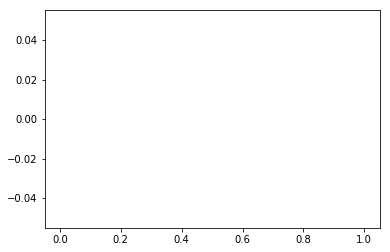

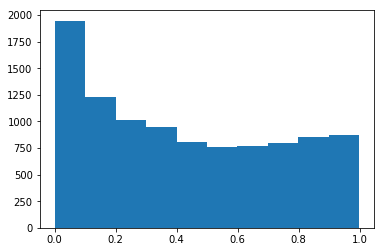

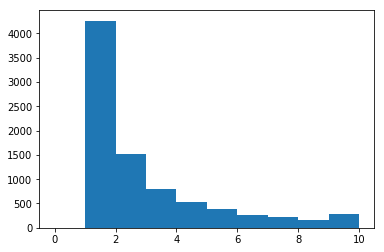

tvt: 10000 8000 1000
len all_pfz 0
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]


In [11]:
def tvt_split(sws, qws):

    all_sz = []
    all_qz = []
    all_pfz = []

    sig = lambda z : 1/(1+numpy.exp(-z))
    obs1 = numpy.zeros((len(sws), len(qws)))
    probs = numpy.zeros((len(sws), len(qws)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    all_pfz=[]
    all_pairs = set()
    attempt_lookup = defaultdict(list)
    cts=[]
    for vi in range(len(sws)):
        for mi in range(len(qws)):
            for _ in range(1):
                all_pairs.add((vi,mi))
                zmask = (qws[mi]<0.0001).astype(int)
                deltas = sws[vi]-qws[mi]
                prs = logistic(deltas,1,0)
                prs = numpy.maximum(zmask,prs)

        #         print(vi,mi)
        #         print("S", students[vi])
        #         print("Q", questions[mi])
        #         print("Z", zmask)
        #         print("D", deltas)
        #         print("p", prs)
        #         print("P", numpy.prod(prs))
                pr = numpy.prod(prs)
                ct=0

                all_sz.append(vi)
                all_qz.append(mi)
                while True:
#                     print("-", end="")
                    rd = random.random()
#                     print(vi, mi, pr, rd)
                    ob = (rd < pr)
                    ct+=1
                    if ob:
#                         print("p")
#                         print("---",ct)
                        break      
                cts.append(ct)
                obs1[vi,mi] = ct
                probs[vi,mi] = pr
#                 all_pfz.append(1.0/ct)
                attempt_lookup[(vi,mi)].append(1.0/ct)
    #             print(vi,mi, numpy.prod(prs))


    print("Ct dracula ==", max(cts))
    obs = numpy.zeros((len(sws), len(qws), max(cts)))
#     obs = {}
    for vi,mi in all_pairs:    #Create 1-hot encoding of observation
        #onehot=numpy.zeros(1+max(cts))
        ct = obs1[vi,mi]
        obs[vi,mi,int(ct)-1]= 1
            
    print("len all_pfz", len(all_pfz))
    plt.hist(all_pfz)
    plt.show()

    plt.hist(probs.flatten())
    plt.show()
    
    plt.hist(cts, range=[0,10])
    plt.show()

    frak=1
    all_pair_ixs = list(range(len(all_pairs)))
    # ixs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10)), replace=True)
    # pairs_to_use = numpy.array(all_pairs)[ixs_to_use]

    all_ixs = all_pair_ixs
    
    val_ixs = numpy.random.choice(all_pair_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
    trn_ixs = list(set(all_ixs) - set(val_ixs))
    test_ixs = numpy.random.choice(trn_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
    trn_ixs = list(set(trn_ixs) - set(test_ixs))
    print("tvt:", len(all_ixs), len(trn_ixs), len(test_ixs))

    all_sz = numpy.array(all_sz).reshape([-1,1])
    all_qz = numpy.array(all_qz).reshape([-1,1])
    all_pfz = numpy.array(all_pfz).reshape([-1,1])
    print("len all_pfz", len(all_pfz))

    all_pairs = sorted(list(all_pairs))
    test_pairs = [all_pairs[ix] for ix in test_ixs]
    val_pairs = [all_pairs[ix] for ix in val_ixs]
    train_pairs = [all_pairs[ix] for ix in trn_ixs]
    
    tsz=[]
    tqz=[]
    tpfz=[]
    
    vsz=[]
    vqz=[]
    vpfz=[]
    
    sz=[]
    qz=[]
    pfz=[]
    
    for tp in test_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            tsz.append(tp[0])
            tqz.append(tp[1])
            tpfz.append(obs[tp[0], tp[1]])
            
    for tp in val_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            vsz.append(tp[0])
            vqz.append(tp[1])
            vpfz.append(obs[tp[0], tp[1]])

    for tp in train_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            sz.append(tp[0])
            qz.append(tp[1])
            pfz.append(obs[tp[0], tp[1]])

    tsz=numpy.array(tsz)
    tqz=numpy.array(tqz)
    tpfz=numpy.array(tpfz)
    
    vsz=numpy.array(vsz)
    vqz=numpy.array(vqz)
    vpfz=numpy.array(vpfz)
    
    sz=numpy.array(sz)
    qz=numpy.array(qz)
    pfz=numpy.array(pfz)
    
    return (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs, max(cts)

(sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs, max_ct = tvt_split(students, questions)

print(vpfz)

In [ ]:
print(obs)

In [ ]:
for ix in range(len(qws)):
    flags = (qws[ix]>1).astype(int) 
    print(flags, sum(flags))
# print((qws>=1).astype(int))

In [ ]:
numpy.set_printoptions(precision=2)
for vi,mi,sc in zip(sz,qz,pfz):
    print(vi,mi,sc)

In [ ]:
# sw = s_table.get_weights()[0]
# qw = qn_table.get_weights()[0]

# print(sw.shape)
# print(qw.shape)

# mm = numpy.dot(qw, sw.T)/n_factors
# # mm = numpy.sum(mm, axis=1)
# print(mm)
m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False)
print(qn_table.get_weights()[0])

In [ ]:
# from keras.callbacks import EarlyStopping
# m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False)

# # print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
# # print(numpy.min(students), numpy.max(students))
# # print("---")
# # qws = qn_table.get_weights()[0]
# # print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
# # print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))

# es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=20)
# prior= sum(pfz)/len(pfz)
# print("prior =",prior)
# initpfz = [prior for _ in range(len(all_pfz))]
# m.fit(x=[all_qz,all_sz], y=numpy.array(initpfz).reshape(-1,1), batch_size=100, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_split=1000/len(initpfz))

In [ ]:
print("TRUE VALS")
# print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(questions), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("--- EMB VALS (prior):")
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(qws), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))


# print(qws)

In [ ]:
print(qz)

preds = m.predict(x=[qz,sz])
for sc_true, sc_hat in zip(pfz[0:100],preds[0:100]):
    print(sc_true, sc_hat)

# print(m.evaluate(x=[mz,vz], y=scz))
from sklearn.metrics import accuracy_score, mean_absolute_error
print(accuracy_score(numpy.around(pfz), numpy.around(preds)  ))

s_scores = defaultdict(list)

for six in range(len(students)):
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    s_scores[six].extend(scs)

for six in range(len(students)):
    s_av = float(numpy.median(s_scores[six]))
    print(six, s_av)


In [ ]:

# wz = m.get_weights()
# s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# qm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=False, q_train=True)
# sm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=True, q_train=False)
bin_arr = numpy.array(list(range(1,max_ct+1)))
print(bin_arr)

w = n_factors
def generate_and_train(qz,sz,pfz, vqz,vsz,vpfz):
    weight_mode="nn"
    if weight_mode=="free":
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo=0)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0)#, regulariser=regularizers.l1(10e-6))
    else:
        s_table =  BigTable((n_students, w), 0, 12, init_hilo=6)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l1(10e-6))
    m = generate_qs_model(qn_table, s_table, Adam(), bins=bin_arr, s_train=True, q_train=True)
    es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=100)
    h = m.fit(x=[qz,sz], y=numpy.array(pfz), batch_size=1000, shuffle=True, epochs=10000, verbose=1, callbacks=[es])#, validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h

s_table, qn_table, m, h = generate_and_train(qz,sz,pfz, vqz,vsz,vpfz)

8000/8000 [==============================] - 5s 629us/step - loss: 3.6496e-04 - mean_squared_error: 8.7180e-05
Epoch 3340/10000
8000/8000 [==============================] - 5s 614us/step - loss: 3.6496e-04 - mean_squared_error: 8.7179e-05
Epoch 3341/10000
8000/8000 [==============================] - 5s 633us/step - loss: 3.6496e-04 - mean_squared_error: 8.7179e-05
Epoch 3342/10000
8000/8000 [==============================] - 5s 649us/step - loss: 3.6496e-04 - mean_squared_error: 8.7178e-05
Epoch 3343/10000
8000/8000 [==============================] - 5s 610us/step - loss: 3.6496e-04 - mean_squared_error: 8.7178e-05
Epoch 3344/10000
8000/8000 [==============================] - 5s 664us/step - loss: 3.6495e-04 - mean_squared_error: 8.7178e-05
Epoch 3345/10000
8000/8000 [==============================] - 5s 618us/step - loss: 3.6495e-04 - mean_squared_error: 8.7177e-05
Epoch 3346/10000
8000/8000 [==============================] - 5s 634us/step - loss: 3.6495e-04 - mean_squared_error: 8.71

8000/8000 [==============================] - 5s 680us/step - loss: 3.6483e-04 - mean_squared_error: 8.7158e-05
Epoch 3404/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6483e-04 - mean_squared_error: 8.7158e-05
Epoch 3405/10000
8000/8000 [==============================] - 5s 656us/step - loss: 3.6483e-04 - mean_squared_error: 8.7158e-05
Epoch 3406/10000
8000/8000 [==============================] - 5s 658us/step - loss: 3.6483e-04 - mean_squared_error: 8.7158e-05
Epoch 3407/10000
8000/8000 [==============================] - 5s 646us/step - loss: 3.6483e-04 - mean_squared_error: 8.7157e-05
Epoch 3408/10000
8000/8000 [==============================] - 5s 637us/step - loss: 3.6482e-04 - mean_squared_error: 8.7157e-05
Epoch 3409/10000
8000/8000 [==============================] - 5s 624us/step - loss: 3.6482e-04 - mean_squared_error: 8.7157e-05
Epoch 3410/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6482e-04 - mean_squared_error: 8.71

8000/8000 [==============================] - 6s 747us/step - loss: 3.6472e-04 - mean_squared_error: 8.7139e-05
Epoch 3468/10000
8000/8000 [==============================] - 5s 661us/step - loss: 3.6472e-04 - mean_squared_error: 8.7139e-05
Epoch 3469/10000
8000/8000 [==============================] - 5s 643us/step - loss: 3.6471e-04 - mean_squared_error: 8.7139e-05
Epoch 3470/10000
8000/8000 [==============================] - 5s 616us/step - loss: 3.6471e-04 - mean_squared_error: 8.7138e-05
Epoch 3471/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6471e-04 - mean_squared_error: 8.7138e-05
Epoch 3472/10000
8000/8000 [==============================] - 5s 650us/step - loss: 3.6471e-04 - mean_squared_error: 8.7138e-05
Epoch 3473/10000
8000/8000 [==============================] - 5s 648us/step - loss: 3.6471e-04 - mean_squared_error: 8.7138e-05
Epoch 3474/10000
8000/8000 [==============================] - 5s 644us/step - loss: 3.6471e-04 - mean_squared_error: 8.71

8000/8000 [==============================] - 5s 641us/step - loss: 3.6462e-04 - mean_squared_error: 8.7123e-05
Epoch 3532/10000
8000/8000 [==============================] - 5s 615us/step - loss: 3.6462e-04 - mean_squared_error: 8.7123e-05
Epoch 3533/10000
8000/8000 [==============================] - 5s 646us/step - loss: 3.6461e-04 - mean_squared_error: 8.7123e-05
Epoch 3534/10000
8000/8000 [==============================] - 5s 616us/step - loss: 3.6461e-04 - mean_squared_error: 8.7123e-05
Epoch 3535/10000
8000/8000 [==============================] - 5s 645us/step - loss: 3.6461e-04 - mean_squared_error: 8.7123e-05
Epoch 3536/10000
8000/8000 [==============================] - 5s 650us/step - loss: 3.6461e-04 - mean_squared_error: 8.7122e-05
Epoch 3537/10000
8000/8000 [==============================] - 5s 647us/step - loss: 3.6461e-04 - mean_squared_error: 8.7122e-05
Epoch 3538/10000
8000/8000 [==============================] - 5s 624us/step - loss: 3.6461e-04 - mean_squared_error: 8.71

8000/8000 [==============================] - 5s 601us/step - loss: 3.6453e-04 - mean_squared_error: 8.7110e-05
Epoch 3596/10000
8000/8000 [==============================] - 5s 608us/step - loss: 3.6453e-04 - mean_squared_error: 8.7110e-05
Epoch 3597/10000
8000/8000 [==============================] - 5s 594us/step - loss: 3.6453e-04 - mean_squared_error: 8.7110e-05
Epoch 3598/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6452e-04 - mean_squared_error: 8.7110e-05
Epoch 3599/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6452e-04 - mean_squared_error: 8.7109e-05
Epoch 3600/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6452e-04 - mean_squared_error: 8.7109e-05
Epoch 3601/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6452e-04 - mean_squared_error: 8.7109e-05
Epoch 3602/10000
8000/8000 [==============================] - 5s 619us/step - loss: 3.6452e-04 - mean_squared_error: 8.71

8000/8000 [==============================] - 5s 599us/step - loss: 3.6445e-04 - mean_squared_error: 8.7099e-05
Epoch 3660/10000
8000/8000 [==============================] - 5s 606us/step - loss: 3.6445e-04 - mean_squared_error: 8.7099e-05
Epoch 3661/10000
8000/8000 [==============================] - 5s 606us/step - loss: 3.6445e-04 - mean_squared_error: 8.7098e-05
Epoch 3662/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6444e-04 - mean_squared_error: 8.7098e-05
Epoch 3663/10000
8000/8000 [==============================] - 5s 597us/step - loss: 3.6444e-04 - mean_squared_error: 8.7098e-05
Epoch 3664/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6444e-04 - mean_squared_error: 8.7098e-05
Epoch 3665/10000
8000/8000 [==============================] - 5s 615us/step - loss: 3.6444e-04 - mean_squared_error: 8.7098e-05
Epoch 3666/10000
8000/8000 [==============================] - 5s 617us/step - loss: 3.6444e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 661us/step - loss: 3.6437e-04 - mean_squared_error: 8.7089e-05
Epoch 3724/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6437e-04 - mean_squared_error: 8.7089e-05
Epoch 3725/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6437e-04 - mean_squared_error: 8.7089e-05
Epoch 3726/10000
8000/8000 [==============================] - 5s 631us/step - loss: 3.6437e-04 - mean_squared_error: 8.7089e-05
Epoch 3727/10000
8000/8000 [==============================] - 5s 636us/step - loss: 3.6437e-04 - mean_squared_error: 8.7089e-05
Epoch 3728/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6437e-04 - mean_squared_error: 8.7088e-05
Epoch 3729/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6437e-04 - mean_squared_error: 8.7088e-05
Epoch 3730/10000
8000/8000 [==============================] - 5s 621us/step - loss: 3.6437e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 636us/step - loss: 3.6431e-04 - mean_squared_error: 8.7081e-05
Epoch 3788/10000
8000/8000 [==============================] - 5s 618us/step - loss: 3.6431e-04 - mean_squared_error: 8.7081e-05
Epoch 3789/10000
8000/8000 [==============================] - 5s 621us/step - loss: 3.6430e-04 - mean_squared_error: 8.7081e-05
Epoch 3790/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6430e-04 - mean_squared_error: 8.7081e-05
Epoch 3791/10000
8000/8000 [==============================] - 5s 622us/step - loss: 3.6430e-04 - mean_squared_error: 8.7080e-05
Epoch 3792/10000
8000/8000 [==============================] - 5s 613us/step - loss: 3.6430e-04 - mean_squared_error: 8.7080e-05
Epoch 3793/10000
8000/8000 [==============================] - 5s 614us/step - loss: 3.6430e-04 - mean_squared_error: 8.7080e-05
Epoch 3794/10000
8000/8000 [==============================] - 5s 598us/step - loss: 3.6430e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 596us/step - loss: 3.6424e-04 - mean_squared_error: 8.7074e-05
Epoch 3852/10000
8000/8000 [==============================] - 5s 593us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3853/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3854/10000
8000/8000 [==============================] - 5s 596us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3855/10000
8000/8000 [==============================] - 5s 596us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3856/10000
8000/8000 [==============================] - 5s 596us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3857/10000
8000/8000 [==============================] - 5s 592us/step - loss: 3.6424e-04 - mean_squared_error: 8.7073e-05
Epoch 3858/10000
8000/8000 [==============================] - 5s 594us/step - loss: 3.6424e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 634us/step - loss: 3.6419e-04 - mean_squared_error: 8.7067e-05
Epoch 3916/10000
8000/8000 [==============================] - 5s 685us/step - loss: 3.6419e-04 - mean_squared_error: 8.7067e-05
Epoch 3917/10000
8000/8000 [==============================] - 5s 683us/step - loss: 3.6419e-04 - mean_squared_error: 8.7068e-05
Epoch 3918/10000
8000/8000 [==============================] - 6s 697us/step - loss: 3.6419e-04 - mean_squared_error: 8.7067e-05
Epoch 3919/10000
8000/8000 [==============================] - 6s 727us/step - loss: 3.6418e-04 - mean_squared_error: 8.7067e-05
Epoch 3920/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6418e-04 - mean_squared_error: 8.7067e-05
Epoch 3921/10000
8000/8000 [==============================] - 5s 633us/step - loss: 3.6418e-04 - mean_squared_error: 8.7067e-05
Epoch 3922/10000
8000/8000 [==============================] - 5s 645us/step - loss: 3.6418e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 652us/step - loss: 3.6414e-04 - mean_squared_error: 8.7062e-05
Epoch 3980/10000
8000/8000 [==============================] - 7s 838us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3981/10000
8000/8000 [==============================] - 6s 716us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3982/10000
8000/8000 [==============================] - 6s 695us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3983/10000
8000/8000 [==============================] - 6s 707us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3984/10000
8000/8000 [==============================] - 6s 711us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3985/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6413e-04 - mean_squared_error: 8.7062e-05
Epoch 3986/10000
8000/8000 [==============================] - 6s 708us/step - loss: 3.6413e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 677us/step - loss: 3.6409e-04 - mean_squared_error: 8.7057e-05
Epoch 4044/10000
8000/8000 [==============================] - 5s 652us/step - loss: 3.6409e-04 - mean_squared_error: 8.7057e-05
Epoch 4045/10000
8000/8000 [==============================] - 5s 668us/step - loss: 3.6408e-04 - mean_squared_error: 8.7057e-05
Epoch 4046/10000
8000/8000 [==============================] - 5s 635us/step - loss: 3.6408e-04 - mean_squared_error: 8.7057e-05
Epoch 4047/10000
8000/8000 [==============================] - 5s 614us/step - loss: 3.6408e-04 - mean_squared_error: 8.7057e-05
Epoch 4048/10000
8000/8000 [==============================] - 5s 626us/step - loss: 3.6408e-04 - mean_squared_error: 8.7057e-05
Epoch 4049/10000
8000/8000 [==============================] - 5s 648us/step - loss: 3.6408e-04 - mean_squared_error: 8.7057e-05
Epoch 4050/10000
8000/8000 [==============================] - 5s 638us/step - loss: 3.6408e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 700us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4108/10000
8000/8000 [==============================] - 6s 717us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4109/10000
8000/8000 [==============================] - 6s 706us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4110/10000
8000/8000 [==============================] - 6s 706us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4111/10000
8000/8000 [==============================] - 6s 713us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4112/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4113/10000
8000/8000 [==============================] - 6s 698us/step - loss: 3.6404e-04 - mean_squared_error: 8.7053e-05
Epoch 4114/10000
8000/8000 [==============================] - 6s 707us/step - loss: 3.6404e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 698us/step - loss: 3.6400e-04 - mean_squared_error: 8.7049e-05
Epoch 4172/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6400e-04 - mean_squared_error: 8.7049e-05
Epoch 4173/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6400e-04 - mean_squared_error: 8.7049e-05
Epoch 4174/10000
8000/8000 [==============================] - 6s 742us/step - loss: 3.6400e-04 - mean_squared_error: 8.7049e-05
Epoch 4175/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6400e-04 - mean_squared_error: 8.7049e-05
Epoch 4176/10000
8000/8000 [==============================] - 5s 616us/step - loss: 3.6399e-04 - mean_squared_error: 8.7049e-05
Epoch 4177/10000
8000/8000 [==============================] - 5s 628us/step - loss: 3.6399e-04 - mean_squared_error: 8.7049e-05
Epoch 4178/10000
8000/8000 [==============================] - 5s 631us/step - loss: 3.6399e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 708us/step - loss: 3.6396e-04 - mean_squared_error: 8.7045e-05
Epoch 4236/10000
8000/8000 [==============================] - 6s 707us/step - loss: 3.6396e-04 - mean_squared_error: 8.7045e-05
Epoch 4237/10000
8000/8000 [==============================] - 6s 704us/step - loss: 3.6396e-04 - mean_squared_error: 8.7045e-05
Epoch 4238/10000
8000/8000 [==============================] - 6s 704us/step - loss: 3.6396e-04 - mean_squared_error: 8.7045e-05
Epoch 4239/10000
8000/8000 [==============================] - 6s 710us/step - loss: 3.6395e-04 - mean_squared_error: 8.7045e-05
Epoch 4240/10000
8000/8000 [==============================] - 6s 704us/step - loss: 3.6395e-04 - mean_squared_error: 8.7045e-05
Epoch 4241/10000
8000/8000 [==============================] - 6s 708us/step - loss: 3.6395e-04 - mean_squared_error: 8.7045e-05
Epoch 4242/10000
8000/8000 [==============================] - 6s 712us/step - loss: 3.6395e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 637us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4300/10000
8000/8000 [==============================] - 5s 644us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4301/10000
8000/8000 [==============================] - 5s 636us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4302/10000
8000/8000 [==============================] - 5s 684us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4303/10000
8000/8000 [==============================] - 6s 688us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4304/10000
8000/8000 [==============================] - 5s 620us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4305/10000
8000/8000 [==============================] - 5s 681us/step - loss: 3.6392e-04 - mean_squared_error: 8.7042e-05
Epoch 4306/10000
8000/8000 [==============================] - 7s 861us/step - loss: 3.6392e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 825us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4364/10000
8000/8000 [==============================] - 6s 795us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4365/10000
8000/8000 [==============================] - 6s 806us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4366/10000
8000/8000 [==============================] - 7s 820us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4367/10000
8000/8000 [==============================] - 6s 780us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4368/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4369/10000
8000/8000 [==============================] - 7s 814us/step - loss: 3.6388e-04 - mean_squared_error: 8.7039e-05
Epoch 4370/10000
8000/8000 [==============================] - 6s 802us/step - loss: 3.6388e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 858us/step - loss: 3.6385e-04 - mean_squared_error: 8.7036e-05
Epoch 4428/10000
8000/8000 [==============================] - 7s 853us/step - loss: 3.6385e-04 - mean_squared_error: 8.7036e-05
Epoch 4429/10000
8000/8000 [==============================] - 7s 833us/step - loss: 3.6385e-04 - mean_squared_error: 8.7036e-05
Epoch 4430/10000
8000/8000 [==============================] - 6s 809us/step - loss: 3.6385e-04 - mean_squared_error: 8.7036e-05
Epoch 4431/10000
8000/8000 [==============================] - 6s 809us/step - loss: 3.6385e-04 - mean_squared_error: 8.7036e-05
Epoch 4432/10000
8000/8000 [==============================] - 6s 756us/step - loss: 3.6384e-04 - mean_squared_error: 8.7036e-05
Epoch 4433/10000
8000/8000 [==============================] - 7s 827us/step - loss: 3.6384e-04 - mean_squared_error: 8.7036e-05
Epoch 4434/10000
8000/8000 [==============================] - 7s 824us/step - loss: 3.6384e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 790us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4492/10000
8000/8000 [==============================] - 6s 812us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4493/10000
8000/8000 [==============================] - 7s 833us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4494/10000
8000/8000 [==============================] - 7s 831us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4495/10000
8000/8000 [==============================] - 7s 832us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4496/10000
8000/8000 [==============================] - 6s 774us/step - loss: 3.6381e-04 - mean_squared_error: 8.7033e-05
Epoch 4497/10000
8000/8000 [==============================] - 7s 843us/step - loss: 3.6381e-04 - mean_squared_error: 8.7034e-05
Epoch 4498/10000
8000/8000 [==============================] - 7s 835us/step - loss: 3.6381e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 785us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4556/10000
8000/8000 [==============================] - 6s 766us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4557/10000
8000/8000 [==============================] - 6s 719us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4558/10000
8000/8000 [==============================] - 6s 713us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4559/10000
8000/8000 [==============================] - 6s 717us/step - loss: 3.6378e-04 - mean_squared_error: 8.7032e-05
Epoch 4560/10000
8000/8000 [==============================] - 6s 732us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4561/10000
8000/8000 [==============================] - 7s 833us/step - loss: 3.6378e-04 - mean_squared_error: 8.7031e-05
Epoch 4562/10000
8000/8000 [==============================] - 7s 894us/step - loss: 3.6378e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 746us/step - loss: 3.6376e-04 - mean_squared_error: 8.7030e-05
Epoch 4620/10000
8000/8000 [==============================] - 6s 808us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4621/10000
8000/8000 [==============================] - 7s 853us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4622/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4623/10000
8000/8000 [==============================] - 7s 820us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4624/10000
8000/8000 [==============================] - 6s 730us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4625/10000
8000/8000 [==============================] - 6s 727us/step - loss: 3.6375e-04 - mean_squared_error: 8.7029e-05
Epoch 4626/10000
8000/8000 [==============================] - 6s 739us/step - loss: 3.6375e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 711us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4684/10000
8000/8000 [==============================] - 6s 712us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4685/10000
8000/8000 [==============================] - 6s 705us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4686/10000
8000/8000 [==============================] - 6s 706us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4687/10000
8000/8000 [==============================] - 6s 695us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4688/10000
8000/8000 [==============================] - 6s 704us/step - loss: 3.6373e-04 - mean_squared_error: 8.7027e-05
Epoch 4689/10000
8000/8000 [==============================] - 6s 711us/step - loss: 3.6372e-04 - mean_squared_error: 8.7027e-05
Epoch 4690/10000
8000/8000 [==============================] - 6s 708us/step - loss: 3.6373e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 809us/step - loss: 3.6370e-04 - mean_squared_error: 8.7026e-05
Epoch 4748/10000
8000/8000 [==============================] - 6s 800us/step - loss: 3.6370e-04 - mean_squared_error: 8.7025e-05
Epoch 4749/10000
8000/8000 [==============================] - 7s 841us/step - loss: 3.6370e-04 - mean_squared_error: 8.7026e-05
Epoch 4750/10000
8000/8000 [==============================] - 7s 834us/step - loss: 3.6370e-04 - mean_squared_error: 8.7026e-05
Epoch 4751/10000
8000/8000 [==============================] - 7s 825us/step - loss: 3.6370e-04 - mean_squared_error: 8.7026e-05
Epoch 4752/10000
8000/8000 [==============================] - 7s 824us/step - loss: 3.6370e-04 - mean_squared_error: 8.7026e-05
Epoch 4753/10000
8000/8000 [==============================] - 7s 821us/step - loss: 3.6370e-04 - mean_squared_error: 8.7025e-05
Epoch 4754/10000
8000/8000 [==============================] - 7s 816us/step - loss: 3.6370e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 775us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4812/10000
8000/8000 [==============================] - 6s 711us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4813/10000
8000/8000 [==============================] - 6s 786us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4814/10000
8000/8000 [==============================] - 6s 736us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4815/10000
8000/8000 [==============================] - 6s 798us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4816/10000
8000/8000 [==============================] - 7s 815us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4817/10000
8000/8000 [==============================] - 6s 750us/step - loss: 3.6368e-04 - mean_squared_error: 8.7024e-05
Epoch 4818/10000
8000/8000 [==============================] - 6s 727us/step - loss: 3.6367e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 8s 944us/step - loss: 3.6365e-04 - mean_squared_error: 8.7023e-05
Epoch 4876/10000
8000/8000 [==============================] - 7s 903us/step - loss: 3.6365e-04 - mean_squared_error: 8.7023e-05
Epoch 4877/10000
8000/8000 [==============================] - 7s 887us/step - loss: 3.6365e-04 - mean_squared_error: 8.7023e-05
Epoch 4878/10000
8000/8000 [==============================] - 7s 853us/step - loss: 3.6365e-04 - mean_squared_error: 8.7023e-05
Epoch 4879/10000
8000/8000 [==============================] - 7s 869us/step - loss: 3.6365e-04 - mean_squared_error: 8.7023e-05
Epoch 4880/10000
8000/8000 [==============================] - 7s 886us/step - loss: 3.6365e-04 - mean_squared_error: 8.7022e-05
Epoch 4881/10000
8000/8000 [==============================] - 7s 892us/step - loss: 3.6365e-04 - mean_squared_error: 8.7022e-05
Epoch 4882/10000
8000/8000 [==============================] - 6s 735us/step - loss: 3.6365e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 722us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4940/10000
8000/8000 [==============================] - 6s 728us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4941/10000
8000/8000 [==============================] - 6s 773us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4942/10000
8000/8000 [==============================] - 6s 733us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4943/10000
8000/8000 [==============================] - 6s 715us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4944/10000
8000/8000 [==============================] - 6s 725us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4945/10000
8000/8000 [==============================] - 6s 723us/step - loss: 3.6363e-04 - mean_squared_error: 8.7021e-05
Epoch 4946/10000
8000/8000 [==============================] - 6s 705us/step - loss: 3.6363e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 843us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5004/10000
8000/8000 [==============================] - 7s 860us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5005/10000
8000/8000 [==============================] - 6s 787us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5006/10000
8000/8000 [==============================] - 6s 788us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5007/10000
8000/8000 [==============================] - 6s 784us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5008/10000
8000/8000 [==============================] - 6s 803us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5009/10000
8000/8000 [==============================] - 6s 787us/step - loss: 3.6361e-04 - mean_squared_error: 8.7020e-05
Epoch 5010/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6361e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 767us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5068/10000
8000/8000 [==============================] - 6s 734us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5069/10000
8000/8000 [==============================] - 6s 714us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5070/10000
8000/8000 [==============================] - 6s 745us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5071/10000
8000/8000 [==============================] - 6s 717us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5072/10000
8000/8000 [==============================] - 6s 703us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5073/10000
8000/8000 [==============================] - 6s 705us/step - loss: 3.6359e-04 - mean_squared_error: 8.7019e-05
Epoch 5074/10000
8000/8000 [==============================] - 6s 706us/step - loss: 3.6359e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 611us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5132/10000
8000/8000 [==============================] - 5s 612us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5133/10000
8000/8000 [==============================] - 5s 626us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5134/10000
8000/8000 [==============================] - 5s 622us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5135/10000
8000/8000 [==============================] - 5s 663us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5136/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5137/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6357e-04 - mean_squared_error: 8.7018e-05
Epoch 5138/10000
8000/8000 [==============================] - 5s 643us/step - loss: 3.6357e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 649us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5196/10000
8000/8000 [==============================] - 6s 709us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5197/10000
8000/8000 [==============================] - 5s 664us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5198/10000
8000/8000 [==============================] - 5s 658us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5199/10000
8000/8000 [==============================] - 5s 638us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5200/10000
8000/8000 [==============================] - 5s 665us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5201/10000
8000/8000 [==============================] - 5s 641us/step - loss: 3.6355e-04 - mean_squared_error: 8.7017e-05
Epoch 5202/10000
8000/8000 [==============================] - 5s 629us/step - loss: 3.6355e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 619us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5260/10000
8000/8000 [==============================] - 5s 613us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5261/10000
8000/8000 [==============================] - 5s 629us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5262/10000
8000/8000 [==============================] - 5s 675us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5263/10000
8000/8000 [==============================] - 5s 641us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5264/10000
8000/8000 [==============================] - 5s 637us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5265/10000
8000/8000 [==============================] - 5s 651us/step - loss: 3.6353e-04 - mean_squared_error: 8.7016e-05
Epoch 5266/10000
8000/8000 [==============================] - 5s 683us/step - loss: 3.6353e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 612us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5324/10000
8000/8000 [==============================] - 5s 626us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5325/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5326/10000
8000/8000 [==============================] - 5s 646us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5327/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5328/10000
8000/8000 [==============================] - 5s 620us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5329/10000
8000/8000 [==============================] - 5s 655us/step - loss: 3.6352e-04 - mean_squared_error: 8.7016e-05
Epoch 5330/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6352e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 683us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5388/10000
8000/8000 [==============================] - 5s 648us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5389/10000
8000/8000 [==============================] - 5s 676us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5390/10000
8000/8000 [==============================] - 5s 612us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5391/10000
8000/8000 [==============================] - 5s 612us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5392/10000
8000/8000 [==============================] - 5s 610us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5393/10000
8000/8000 [==============================] - 5s 630us/step - loss: 3.6350e-04 - mean_squared_error: 8.7015e-05
Epoch 5394/10000
8000/8000 [==============================] - 6s 732us/step - loss: 3.6350e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 605us/step - loss: 3.6349e-04 - mean_squared_error: 8.7015e-05
Epoch 5452/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6349e-04 - mean_squared_error: 8.7014e-05
Epoch 5453/10000
8000/8000 [==============================] - 5s 605us/step - loss: 3.6349e-04 - mean_squared_error: 8.7015e-05
Epoch 5454/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6349e-04 - mean_squared_error: 8.7015e-05
Epoch 5455/10000
8000/8000 [==============================] - 5s 606us/step - loss: 3.6349e-04 - mean_squared_error: 8.7015e-05
Epoch 5456/10000
8000/8000 [==============================] - 5s 605us/step - loss: 3.6349e-04 - mean_squared_error: 8.7014e-05
Epoch 5457/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6348e-04 - mean_squared_error: 8.7014e-05
Epoch 5458/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6349e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 604us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5516/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5517/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5518/10000
8000/8000 [==============================] - 5s 616us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5519/10000
8000/8000 [==============================] - 5s 607us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5520/10000
8000/8000 [==============================] - 5s 607us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5521/10000
8000/8000 [==============================] - 5s 607us/step - loss: 3.6347e-04 - mean_squared_error: 8.7014e-05
Epoch 5522/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6347e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 608us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5580/10000
8000/8000 [==============================] - 5s 598us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5581/10000
8000/8000 [==============================] - 5s 611us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5582/10000
8000/8000 [==============================] - 5s 617us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5583/10000
8000/8000 [==============================] - 5s 624us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5584/10000
8000/8000 [==============================] - 5s 623us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5585/10000
8000/8000 [==============================] - 5s 628us/step - loss: 3.6346e-04 - mean_squared_error: 8.7014e-05
Epoch 5586/10000
8000/8000 [==============================] - 5s 656us/step - loss: 3.6346e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 597us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5644/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5645/10000
8000/8000 [==============================] - 5s 608us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5646/10000
8000/8000 [==============================] - 5s 599us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5647/10000
8000/8000 [==============================] - 5s 605us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5648/10000
8000/8000 [==============================] - 5s 595us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5649/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6344e-04 - mean_squared_error: 8.7014e-05
Epoch 5650/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6344e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 607us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5708/10000
8000/8000 [==============================] - 5s 596us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5709/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5710/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5711/10000
8000/8000 [==============================] - 5s 614us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5712/10000
8000/8000 [==============================] - 5s 608us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5713/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6343e-04 - mean_squared_error: 8.7013e-05
Epoch 5714/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6343e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 597us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5772/10000
8000/8000 [==============================] - 5s 606us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5773/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5774/10000
8000/8000 [==============================] - 5s 614us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5775/10000
8000/8000 [==============================] - 5s 598us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5776/10000
8000/8000 [==============================] - 5s 599us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5777/10000
8000/8000 [==============================] - 5s 601us/step - loss: 3.6342e-04 - mean_squared_error: 8.7013e-05
Epoch 5778/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6342e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 598us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5836/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5837/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5838/10000
8000/8000 [==============================] - 5s 595us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5839/10000
8000/8000 [==============================] - 5s 594us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5840/10000
8000/8000 [==============================] - 5s 595us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5841/10000
8000/8000 [==============================] - 5s 599us/step - loss: 3.6341e-04 - mean_squared_error: 8.7013e-05
Epoch 5842/10000
8000/8000 [==============================] - 5s 656us/step - loss: 3.6341e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 669us/step - loss: 3.6340e-04 - mean_squared_error: 8.7012e-05
Epoch 5900/10000
8000/8000 [==============================] - 6s 688us/step - loss: 3.6340e-04 - mean_squared_error: 8.7013e-05
Epoch 5901/10000
8000/8000 [==============================] - 5s 669us/step - loss: 3.6340e-04 - mean_squared_error: 8.7012e-05
Epoch 5902/10000
8000/8000 [==============================] - 5s 639us/step - loss: 3.6340e-04 - mean_squared_error: 8.7013e-05
Epoch 5903/10000
8000/8000 [==============================] - 5s 665us/step - loss: 3.6340e-04 - mean_squared_error: 8.7012e-05
Epoch 5904/10000
8000/8000 [==============================] - 5s 657us/step - loss: 3.6340e-04 - mean_squared_error: 8.7012e-05
Epoch 5905/10000
8000/8000 [==============================] - 6s 688us/step - loss: 3.6340e-04 - mean_squared_error: 8.7012e-05
Epoch 5906/10000
8000/8000 [==============================] - 5s 656us/step - loss: 3.6340e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 648us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5964/10000
8000/8000 [==============================] - 5s 654us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5965/10000
8000/8000 [==============================] - 6s 733us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5966/10000
8000/8000 [==============================] - 5s 632us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5967/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5968/10000
8000/8000 [==============================] - 5s 610us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5969/10000
8000/8000 [==============================] - 5s 613us/step - loss: 3.6339e-04 - mean_squared_error: 8.7012e-05
Epoch 5970/10000
8000/8000 [==============================] - 5s 624us/step - loss: 3.6339e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 643us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6028/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6029/10000
8000/8000 [==============================] - 5s 683us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6030/10000
8000/8000 [==============================] - 5s 670us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6031/10000
8000/8000 [==============================] - 6s 771us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6032/10000
8000/8000 [==============================] - 6s 790us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6033/10000
8000/8000 [==============================] - 6s 748us/step - loss: 3.6338e-04 - mean_squared_error: 8.7012e-05
Epoch 6034/10000
8000/8000 [==============================] - 6s 714us/step - loss: 3.6338e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 642us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6092/10000
8000/8000 [==============================] - 6s 719us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6093/10000
8000/8000 [==============================] - 5s 676us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6094/10000
8000/8000 [==============================] - 6s 719us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6095/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6096/10000
8000/8000 [==============================] - 5s 650us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6097/10000
8000/8000 [==============================] - 5s 667us/step - loss: 3.6337e-04 - mean_squared_error: 8.7012e-05
Epoch 6098/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6337e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 785us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6156/10000
8000/8000 [==============================] - 6s 767us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6157/10000
8000/8000 [==============================] - 6s 788us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6158/10000
8000/8000 [==============================] - 6s 737us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6159/10000
8000/8000 [==============================] - 6s 745us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6160/10000
8000/8000 [==============================] - 6s 748us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6161/10000
8000/8000 [==============================] - 6s 780us/step - loss: 3.6336e-04 - mean_squared_error: 8.7012e-05
Epoch 6162/10000
8000/8000 [==============================] - 7s 847us/step - loss: 3.6336e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 665us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6220/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6221/10000
8000/8000 [==============================] - 7s 813us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6222/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6223/10000
8000/8000 [==============================] - 6s 800us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6224/10000
8000/8000 [==============================] - 6s 805us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6225/10000
8000/8000 [==============================] - 6s 802us/step - loss: 3.6335e-04 - mean_squared_error: 8.7012e-05
Epoch 6226/10000
8000/8000 [==============================] - 6s 795us/step - loss: 3.6335e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 699us/step - loss: 3.6334e-04 - mean_squared_error: 8.7011e-05
Epoch 6284/10000
8000/8000 [==============================] - 5s 665us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6285/10000
8000/8000 [==============================] - 6s 757us/step - loss: 3.6334e-04 - mean_squared_error: 8.7011e-05
Epoch 6286/10000
8000/8000 [==============================] - 6s 803us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6287/10000
8000/8000 [==============================] - 6s 812us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6288/10000
8000/8000 [==============================] - 6s 807us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6289/10000
8000/8000 [==============================] - 6s 796us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6290/10000
8000/8000 [==============================] - 6s 801us/step - loss: 3.6334e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 879us/step - loss: 3.6334e-04 - mean_squared_error: 8.7011e-05
Epoch 6348/10000
8000/8000 [==============================] - 7s 840us/step - loss: 3.6334e-04 - mean_squared_error: 8.7012e-05
Epoch 6349/10000
8000/8000 [==============================] - 7s 833us/step - loss: 3.6334e-04 - mean_squared_error: 8.7011e-05
Epoch 6350/10000
8000/8000 [==============================] - 7s 823us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6351/10000
8000/8000 [==============================] - 7s 825us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6352/10000
8000/8000 [==============================] - 7s 816us/step - loss: 3.6334e-04 - mean_squared_error: 8.7011e-05
Epoch 6353/10000
8000/8000 [==============================] - 7s 821us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6354/10000
8000/8000 [==============================] - 7s 825us/step - loss: 3.6334e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 613us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6412/10000
8000/8000 [==============================] - 5s 674us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6413/10000
8000/8000 [==============================] - 5s 660us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6414/10000
8000/8000 [==============================] - 6s 713us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6415/10000
8000/8000 [==============================] - 5s 685us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6416/10000
8000/8000 [==============================] - 6s 705us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6417/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6333e-04 - mean_squared_error: 8.7011e-05
Epoch 6418/10000
8000/8000 [==============================] - 6s 700us/step - loss: 3.6333e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 849us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6476/10000
8000/8000 [==============================] - 6s 741us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6477/10000
8000/8000 [==============================] - 6s 763us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6478/10000
8000/8000 [==============================] - 6s 792us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6479/10000
8000/8000 [==============================] - 7s 820us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6480/10000
8000/8000 [==============================] - 6s 799us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6481/10000
8000/8000 [==============================] - 6s 782us/step - loss: 3.6332e-04 - mean_squared_error: 8.7011e-05
Epoch 6482/10000
8000/8000 [==============================] - 6s 798us/step - loss: 3.6332e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 7s 858us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6540/10000
8000/8000 [==============================] - 6s 790us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6541/10000
8000/8000 [==============================] - 6s 784us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6542/10000
8000/8000 [==============================] - 6s 783us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6543/10000
8000/8000 [==============================] - 6s 808us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6544/10000
8000/8000 [==============================] - 6s 789us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6545/10000
8000/8000 [==============================] - 6s 810us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6546/10000
8000/8000 [==============================] - 6s 800us/step - loss: 3.6331e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 799us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6604/10000
8000/8000 [==============================] - 6s 806us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6605/10000
8000/8000 [==============================] - 6s 796us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6606/10000
8000/8000 [==============================] - 6s 810us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6607/10000
8000/8000 [==============================] - 6s 805us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6608/10000
8000/8000 [==============================] - 7s 915us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6609/10000
8000/8000 [==============================] - 7s 846us/step - loss: 3.6331e-04 - mean_squared_error: 8.7011e-05
Epoch 6610/10000
8000/8000 [==============================] - 6s 804us/step - loss: 3.6331e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 806us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6668/10000
8000/8000 [==============================] - 6s 806us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6669/10000
8000/8000 [==============================] - 6s 809us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6670/10000
8000/8000 [==============================] - 6s 802us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6671/10000
8000/8000 [==============================] - 6s 793us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6672/10000
8000/8000 [==============================] - 6s 795us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6673/10000
8000/8000 [==============================] - 6s 799us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6674/10000
8000/8000 [==============================] - 6s 803us/step - loss: 3.6330e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 698us/step - loss: 3.6330e-04 - mean_squared_error: 8.7011e-05
Epoch 6732/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6733/10000
8000/8000 [==============================] - 6s 717us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6734/10000
8000/8000 [==============================] - 6s 717us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6735/10000
8000/8000 [==============================] - 6s 726us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6736/10000
8000/8000 [==============================] - 6s 747us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6737/10000
8000/8000 [==============================] - 6s 715us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6738/10000
8000/8000 [==============================] - 6s 699us/step - loss: 3.6329e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 602us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6796/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6797/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6798/10000
8000/8000 [==============================] - 5s 608us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6799/10000
8000/8000 [==============================] - 5s 600us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6800/10000
8000/8000 [==============================] - 5s 599us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6801/10000
8000/8000 [==============================] - 5s 607us/step - loss: 3.6329e-04 - mean_squared_error: 8.7011e-05
Epoch 6802/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6329e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 691us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6860/10000
8000/8000 [==============================] - 6s 700us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6861/10000
8000/8000 [==============================] - 6s 695us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6862/10000
8000/8000 [==============================] - 6s 693us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6863/10000
8000/8000 [==============================] - 6s 691us/step - loss: 3.6328e-04 - mean_squared_error: 8.7010e-05
Epoch 6864/10000
8000/8000 [==============================] - 6s 713us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6865/10000
8000/8000 [==============================] - 6s 720us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6866/10000
8000/8000 [==============================] - 6s 713us/step - loss: 3.6328e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 602us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6924/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6925/10000
8000/8000 [==============================] - 5s 605us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6926/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6927/10000
8000/8000 [==============================] - 5s 596us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6928/10000
8000/8000 [==============================] - 6s 720us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6929/10000
8000/8000 [==============================] - 6s 700us/step - loss: 3.6328e-04 - mean_squared_error: 8.7011e-05
Epoch 6930/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6328e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 692us/step - loss: 3.6327e-04 - mean_squared_error: 8.7010e-05
Epoch 6988/10000
8000/8000 [==============================] - 6s 691us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6989/10000
8000/8000 [==============================] - 6s 688us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6990/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6991/10000
8000/8000 [==============================] - 6s 714us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6992/10000
8000/8000 [==============================] - 6s 718us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6993/10000
8000/8000 [==============================] - 6s 701us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 6994/10000
8000/8000 [==============================] - 5s 666us/step - loss: 3.6327e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 676us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 7052/10000
8000/8000 [==============================] - 6s 702us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 7053/10000
8000/8000 [==============================] - 5s 680us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 7054/10000
8000/8000 [==============================] - 5s 685us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 7055/10000
8000/8000 [==============================] - 6s 742us/step - loss: 3.6327e-04 - mean_squared_error: 8.7010e-05
Epoch 7056/10000
8000/8000 [==============================] - 6s 694us/step - loss: 3.6327e-04 - mean_squared_error: 8.7010e-05
Epoch 7057/10000
8000/8000 [==============================] - 5s 676us/step - loss: 3.6327e-04 - mean_squared_error: 8.7011e-05
Epoch 7058/10000
8000/8000 [==============================] - 5s 679us/step - loss: 3.6327e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 709us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7116/10000
8000/8000 [==============================] - 6s 700us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7117/10000
8000/8000 [==============================] - 5s 684us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7118/10000
8000/8000 [==============================] - 6s 694us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7119/10000
8000/8000 [==============================] - 6s 699us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7120/10000
8000/8000 [==============================] - 6s 692us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7121/10000
8000/8000 [==============================] - 6s 692us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7122/10000
8000/8000 [==============================] - 6s 694us/step - loss: 3.6326e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 711us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7180/10000
8000/8000 [==============================] - 6s 688us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7181/10000
8000/8000 [==============================] - 5s 685us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7182/10000
8000/8000 [==============================] - 5s 685us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7183/10000
8000/8000 [==============================] - 5s 684us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7184/10000
8000/8000 [==============================] - 6s 691us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7185/10000
8000/8000 [==============================] - 6s 701us/step - loss: 3.6326e-04 - mean_squared_error: 8.7010e-05
Epoch 7186/10000
8000/8000 [==============================] - 5s 627us/step - loss: 3.6326e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 698us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7244/10000
8000/8000 [==============================] - 5s 684us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7245/10000
8000/8000 [==============================] - 5s 684us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7246/10000
8000/8000 [==============================] - 6s 749us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7247/10000
8000/8000 [==============================] - 6s 805us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7248/10000
8000/8000 [==============================] - 7s 834us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7249/10000
8000/8000 [==============================] - 6s 715us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7250/10000
8000/8000 [==============================] - 5s 623us/step - loss: 3.6325e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 603us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7308/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7309/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7310/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7311/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7312/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7313/10000
8000/8000 [==============================] - 5s 604us/step - loss: 3.6325e-04 - mean_squared_error: 8.7010e-05
Epoch 7314/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6325e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 5s 606us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7372/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7373/10000
8000/8000 [==============================] - 5s 597us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7374/10000
8000/8000 [==============================] - 5s 607us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7375/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7376/10000
8000/8000 [==============================] - 5s 603us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7377/10000
8000/8000 [==============================] - 5s 602us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7378/10000
8000/8000 [==============================] - 5s 599us/step - loss: 3.6324e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 789us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7436/10000
8000/8000 [==============================] - 6s 788us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7437/10000
8000/8000 [==============================] - 6s 795us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7438/10000
8000/8000 [==============================] - 7s 817us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7439/10000
8000/8000 [==============================] - 7s 824us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7440/10000
8000/8000 [==============================] - 6s 777us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7441/10000
8000/8000 [==============================] - 6s 791us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7442/10000
8000/8000 [==============================] - 6s 790us/step - loss: 3.6324e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 690us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7500/10000
8000/8000 [==============================] - 6s 693us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7501/10000
8000/8000 [==============================] - 6s 695us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7502/10000
8000/8000 [==============================] - 6s 705us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7503/10000
8000/8000 [==============================] - 6s 722us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7504/10000
8000/8000 [==============================] - 6s 694us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7505/10000
8000/8000 [==============================] - 6s 795us/step - loss: 3.6324e-04 - mean_squared_error: 8.7010e-05
Epoch 7506/10000
8000/8000 [==============================] - 6s 712us/step - loss: 3.6324e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 750us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7564/10000
8000/8000 [==============================] - 6s 731us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7565/10000
8000/8000 [==============================] - 6s 755us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7566/10000
8000/8000 [==============================] - 7s 842us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7567/10000
8000/8000 [==============================] - 6s 775us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7568/10000
8000/8000 [==============================] - 6s 798us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7569/10000
8000/8000 [==============================] - 6s 771us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7570/10000
8000/8000 [==============================] - 6s 811us/step - loss: 3.6323e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 756us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7628/10000
8000/8000 [==============================] - 6s 764us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7629/10000
8000/8000 [==============================] - 6s 778us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7630/10000
8000/8000 [==============================] - 6s 757us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7631/10000
8000/8000 [==============================] - 6s 755us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7632/10000
8000/8000 [==============================] - 6s 761us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7633/10000
8000/8000 [==============================] - 6s 755us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7634/10000
8000/8000 [==============================] - 6s 758us/step - loss: 3.6323e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 755us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7692/10000
8000/8000 [==============================] - 6s 764us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7693/10000
8000/8000 [==============================] - 6s 762us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7694/10000
8000/8000 [==============================] - 6s 764us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7695/10000
8000/8000 [==============================] - 6s 760us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7696/10000
8000/8000 [==============================] - 6s 762us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7697/10000
8000/8000 [==============================] - 6s 764us/step - loss: 3.6323e-04 - mean_squared_error: 8.7010e-05
Epoch 7698/10000
8000/8000 [==============================] - 6s 767us/step - loss: 3.6322e-04 - mean_squared_error: 8.70

8000/8000 [==============================] - 6s 763us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7756/10000
8000/8000 [==============================] - 6s 765us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7757/10000
8000/8000 [==============================] - 6s 761us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7758/10000
8000/8000 [==============================] - 6s 767us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7759/10000
8000/8000 [==============================] - 6s 767us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7760/10000
8000/8000 [==============================] - 6s 765us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7761/10000
8000/8000 [==============================] - 6s 760us/step - loss: 3.6322e-04 - mean_squared_error: 8.7010e-05
Epoch 7762/10000
8000/8000 [==============================] - 6s 771us/step - loss: 3.6322e-04 - mean_squared_error: 8.70

In [ ]:
for six in range(len(students)):
    print("....",six)
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    for qix in range(len(questions)):
        print(qix, " : ")
        for s,o in zip(scs[qix], obs[six,qix]):
            print("....",s,o)
            if s==0:
                print("ZZZZ ZZZ ZZ")
                break
#     s_scores[six].extend(scs)

# for six in range(len(students)):
#     s_av = float(numpy.median(s_scores[six]))
#     print(six, s_av)
    
    
    

In [ ]:
def plot_history(history):
    plt.plot(history.history['mean_squared_error'])
#     plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('MSE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(h)

In [ ]:
right_ct=0
# preds = m.predict(x=[qz,sz])
# for q,s, sc_obsv, sc_hat in zip(qz,sz,pfz,preds):
#     print(q,s, sc_obsv, sc_hat, "right" if (numpy.around(sc_obsv)==numpy.around(sc_hat)) else "X")

print(len(pfz), len(tpfz))
right_ct=0
preds = m.predict(x=[tqz,tsz]).flatten()
print(preds)
# flags = numpy.random.random(size=len(preds))
# print(flags)
# preds = flags <= preds
ground_truths = []
zipd_list = sorted(list(zip(tsz, tqz,tpfz,preds)))
for s,q, sc_obsv, sc_hat in zipd_list:
#     sc_hat_stoc = (random.random() < sc_hat)
    pr = probs[s,q]
    print(q,s, sc_obsv, pr, sc_hat, "right" if (numpy.around(pr)==numpy.around(sc_hat)) else "X")
    ground_truths.append((pr,sc_hat))
#     print(sc_obsv, sc_hat, res)

# print(m.evaluate(x=[tmz,tvz], y=tscz))

from sklearn.metrics import accuracy_score, mean_absolute_error
print(preds.shape)

# print(right_ct / len(tpfz))

print("#########")
for (g,p) in ground_truths:
    print(g,p)

print("obvsd acc", accuracy_score(numpy.around([g[0] for g in ground_truths]), numpy.around([g[1] for g in ground_truths])))
# print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
# print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
for qix in range(len(questions)):
    kcs = numpy.argwhere(questions[qix] > 1)
    
    klevs = questions[qix][kcs.flatten()] 
    print(qix, ["{}={}".format(k,round(klev,2)) for (k,klev) in zip(kcs.flatten(),klevs)])

In [ ]:
qws = qn_table.get_weights()[0]
print(len(qws.flatten()))
print(len(questions.flatten()))
item_RMSE = numpy.sqrt(numpy.mean(numpy.square(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten()))))
item_MAE = numpy.mean(numpy.abs(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten())))
# item_RMSE = numpy.sqrt(numpy.mean(numpy.square(qws.flatten() - questions.flatten())))
# item_MAE = numpy.mean(numpy.abs(qws.flatten() - questions.flatten()))

print(item_RMSE, item_MAE)

In [ ]:
# preds = m.predict([tqz,tsz])
# for pred,q,s in zip(preds,tqz,tsz):
#     print(q, pred)

qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# qmin = min(qws)

offset = numpy.min(students) - numpy.min(sws) 

numpy.set_printoptions(precision=2)

seen = set()
for qix,six in zip(tqz, tsz):
    if (int(qix),int(six)) in seen:
        continue
    else:
        seen.add((int(qix),int(six)))
    qrow = questions[qix].flatten()
    srow = students[six].flatten()
    qhat = qws[qix].flatten() #+ offset
    shat = sws[six].flatten() #+ offset
#     print(qix, six, (srow, shat), (qrow, qhat), srow-qrow, shat-qhat)
    print("STUDENT", six)
    print(srow)
    print(shat)
    print("VS Q", qix)
    print(qrow)
    print(qhat)#, " >>>", srow-qrow, shat-qhat)
    print("Comp. Prs:")
    for s,q in ((srow,qrow), (shat,qhat)):
        zmask = (q<0.0001).astype(int)
        deltas = s-q
        prs = logistic(deltas,1,0)
        prs = numpy.maximum(zmask,prs)
        print(prs, numpy.prod(prs))
    
print(len(sws))
print(len(students))

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

scr = StandardScaler(with_mean=False, with_std=False)
plt.hist(scr.fit_transform(students.reshape(-1,1)), alpha=0.5, bins=bin_spread(students))
plt.hist(scr.fit_transform(sws.reshape(-1,1)), alpha=0.4, bins=bin_spread(sws))
plt.show()
plt.hist(scr.fit_transform(questions.reshape(-1,1)), alpha=0.5, bins=bin_spread(questions))
print(bin_spread(qws))
plt.hist(scr.fit_transform(qws.reshape(-1,1)), alpha=0.4, bins=bin_spread(qws))
plt.show()

In [ ]:
print(numpy.min(qws), numpy.max(qws))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
    print("Threshold:", threshold)
    bool_preds = (preds >= threshold)
    print(confusion_matrix(tpfz, bool_preds))
    print(accuracy_score(tpfz, bool_preds))
    print(" ")

bool_preds = numpy.around(preds)
print("obvsd acc", accuracy_score(tpfz, numpy.around(preds)))
#.8263 v 7814

In [ ]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = questions

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

itemz_pred = items_chosen
n = len(items_chosen)
itemz = questions

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
def plot_items(pred_list, real_items):
    base = min( numpy.min(pred_list), numpy.min(real_items) )
    pca = PCA(n_components=2)
    real_items = real_items - base
    fyrst = True
    for preds in pred_list:
        preds = preds - base
        split = 0
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)
        itemz_pred = items_chosen
        n = len(items_chosen)
        itemz = real_items
        itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)

        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        if fyrst:
            fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
            for j in range(n):
                fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
            fyrst=False
        fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
            fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
            

    plt.show()

plot_items([qws], questions)

In [ ]:
numpy.random.seed(666)
_, _, students2, _  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)
(sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tvt_split(students2, questions)
w=n_factors
s_table2 =  BigTable((n_students, w), 0, 12, init_hilo=None)#, regulariser=regularizers.l2(10e-6))
qn_table2 = BigTable((n_questions, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l1(10e-6))

In [ ]:
m2 = generate_qs_model(qn_table2, s_table2, Adam(), comp_lims=False, s_train=True, q_train=True)
es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)

In [ ]:
h = m2.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=1000, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])

In [ ]:
sws2= s_table2.get_weights()[0]
qws2= qn_table2.get_weights()[0]
bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))
plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
plt.hist(sws2.flatten(), alpha=0.4, bins=bin_spread(sws2))
plt.show()
plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
print(bin_spread(qws2))
plt.hist(qws2.flatten(), alpha=0.4, bins=bin_spread(qws2))
plt.show()

In [ ]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
n_factors, min_active, max_active = (2, 1, 2)

for _ in range(100):
    n_students = int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = int(numpy.random.uniform(15,35, size=1))
    a1 = numpy.random.uniform(1, 3.5, size=1)
    a0 = numpy.random.uniform(-0.5,1, size=1)
    av_c = (min_active + max_active)/2
    offset = pr_to_spread(0.5, comps=av_c, as_A_and_D=False)
    a0 = a0 + offset
    test_w = numpy.random.uniform(0.5, 3.5)
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))
    
    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)

    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()


